In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from io import StringIO

In [2]:
k = 3
m = 60
m_cluster_sample_size = int(m/4)
normal_stdvar = 0.10
noise_stdvar = 0.45

In [3]:
#Set up random generation object
rng = np.random.default_rng()

#generate m random points in the square [0,1]*[0,1]
#Four sets of points are generated by different normal distributions.
#Three represent "clusterable" points, and a fourth is just noise.
#The sum of the four sets are of length "m"
points_cluster_1 = rng.normal(
    loc=(0, 0), 
    scale=normal_stdvar, 
    size=(m_cluster_sample_size,2))

points_cluster_2 = rng.normal(
    loc=(0, 0.8), 
    scale=normal_stdvar, 
    size=(m_cluster_sample_size,2))

points_cluster_3 = rng.normal(
    loc=(0.5, 0.5), 
    scale=normal_stdvar, 
    size=(m_cluster_sample_size,2))

points_noise = rng.normal(
    loc=(0.5, 0.5),
    scale=noise_stdvar, 
    size=(m_cluster_sample_size,2))

points = np.concatenate((points_cluster_1, points_cluster_2, points_cluster_3, points_noise))

#We normalize the points between [0,1]*[0,1], just in case the generators made points out of the scope.
points = (points-np.min(points))/(np.max(points)-np.min(points))

#generate matrix distance
dist = [[math.sqrt((i[0]-j[0])**2+(i[1]-j[1])**2) for i in points] for j in points]
print(len(dist[3]))
        

60


In [4]:
#We write the generated data in a .dat AMPL format.
output = open("Kcluster.dat", "w")
output.write('param k:= '+ str(k) + ';')
output.write('\n')
output.write('param m:= '+ str(m) + ';')
output.write('\n')
output.write('param d: ')
for i in range(m):output.write(str(i + 1) + ' ')
output.write(':=')
output.write('\n')
for i in range(m):
    output.write(str(i + 1) + ' ')
    for j in range(m):
        output.write(str(dist[i][j]))
        if(j != m-1):output.write(' ')
    if(i != m-1):output.write('\n')
output.write(';')
output.write('\n')
output.close()

<function matplotlib.pyplot.show(close=None, block=None)>

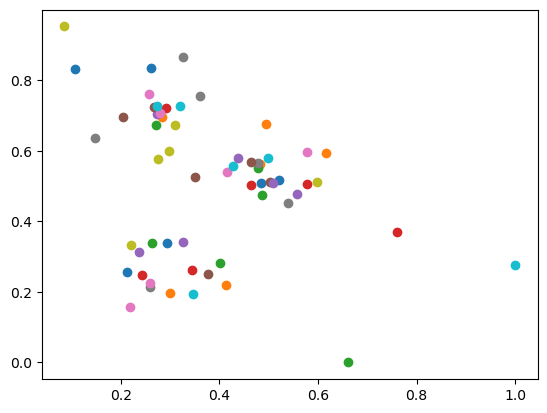

In [5]:
for point in points:
    plt.scatter(point[0], point[1])
plt.show

In [9]:
print(open("solution_matrix.txt", "r").readlines())

['x [*,*]\n', ':    1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60    :=\n', '1    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0\n', '2    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0\n', '3    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0 

In [22]:
solution_input = open("solution_matrix.txt", "r")
data_str =''
for line in solution_input.readlines():
    # Read all lines from the file and join them into a single string
    data_str = data_str + line

# Use StringIO to convert the string into a file-like object
data_file = StringIO(data_str)

# Skip the header lines and read the data into a DataFrame
df = pd.read_csv(data_file, delim_whitespace=True, skiprows=2, header=None)

# Set the column names to the values in the header row
header_row = data_str.splitlines()[1].split()
df = df.drop(12).drop(0, axis=1)

# Reset the index to match your data
df.reset_index(drop=True, inplace=True)

# Display the DataFrame
print(df)




     1    2    3    4    5    6    7    8    9    10  ...   51   52   53   54  \
0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
1   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
2   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
3   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
4   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
5   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
6   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
7   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
8   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
9   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
10  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
11  0.0  0.0  0.0  0.0  0.0 

In [34]:
print(df[3].to_list())
for i in range(0, len(df)):
    print(i)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
